### Imports

In [82]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import numpy as np
import glob2
import h5py
import matplotlib.pyplot as plt
import cv2
import glob2

%matplotlib inline

### Config from modules for ipynb

In [2]:
import ipynb
import importlib
import ipynb.fs.full.modules.Config as ipynb_config

In [3]:
importlib.reload(ipynb_config)

<module 'ipynb.fs.full.modules.Config' (/Users/dieumynguyen/Desktop/Projects/bee_communication_v2/ipynb/modules/Config.ipynb)>

In [23]:
X_MIN = ipynb_config.X_MIN
X_MAX = ipynb_config.X_MAX
DX = ipynb_config.DX
GRID_SIZE = np.arange(X_MIN, X_MAX+DX, DX).shape[0]
D = ipynb_config.DIFFUSION_COEFFICIENT
DECAY = ipynb_config.DECAY
T_MIN = ipynb_config.T_MIN
T_MAX = ipynb_config.T_MAX
DT = ipynb_config.DT
NUM_TIMESTEPS = np.arange(T_MIN, T_MAX+DT, DT).shape[0]
QUEEN_BEE_A = ipynb_config.QUEEN_INITIAL_CONCENTRATION
WORKER_BEE_A = ipynb_config.WORKER_INITIAL_CONCENTRATION
THRESHOLD = ipynb_config.WORKER_THRESHOLD
WB = ipynb_config.WORKER_BIAS_SCALAR
SEED = ipynb_config.RANDOM_SEED
convert_xy_to_index = lambda xy: ((xy - X_MIN) / (X_MAX - X_MIN)) * GRID_SIZE

### Config from script 

In [127]:
def read_config(base_exp_dir):
    cfg_path = glob2.glob(f"{base_exp_dir}/*.cfg")[0]
    cfg_path, os.path.exists(cfg_path)

    with open(cfg_path, "r") as infile:
        lines = [line.split() for line in infile]
        cfg_opts = {}
        for key, val in lines:
            key = key.replace('--', '')

            try:
                val = float(val)
            except:
                try:
                    val = int(val)
                except:
                    if val.startswith("T"):
                        val = True
                    elif val.startswith("F"):
                        val = False
                    pass
            cfg_opts[key] = val
    return cfg_opts

In [128]:
base_exp_dir = "../script/experiments/experiment_6__2019-01-27_14-12-12/Q0.15_W0.15_D0.6_T0.01_wb5.0_decay18.0_seed10"
os.path.exists(base_exp_dir)


True

In [130]:
script_config = read_config(base_exp_dir)

### Read h5 data & visualization

In [131]:
ipynb_dev_config = False

In [132]:
if not ipynb_dev_config:
    env_path = os.path.join(base_exp_dir, "envir_hist.h5")
    bee_path = os.path.join(base_exp_dir, "bee_hist.h5")
    print(os.path.exists(env_path), os.path.exists(bee_path), env_path)
else: 
    base_exp_dir = "./"
    env_path = os.path.join(base_exp_dir, "envir_hist.h5")
    bee_path = os.path.join(base_exp_dir, "bee_hist.h5")
    print(os.path.exists(env_path), os.path.exists(bee_path), env_path)


True True ../script/experiments/experiment_6__2019-01-27_14-12-12/Q0.15_W0.15_D0.6_T0.01_wb5.0_decay18.0_seed10/envir_hist.h5


- #### Concentration maps

In [133]:
with h5py.File(env_path, 'r') as infile:
    cmaps = np.array(infile['concentration'])

In [134]:
# Min and max concentrations for heatmap
min_c = np.min(cmaps)
max_c = np.max(cmaps) * 0.8
min_c, max_c

(1.9569013630556178e-66, 0.9726845232912235)

- #### Bee measurements

In [135]:
bee_data = {}
with h5py.File(bee_path, 'r') as infile:
    for key, val in infile.items():
        bee_data[key] = np.array(val)

In [136]:
bee_nums = np.unique(bee_data['bee_i'])
bees = {}
for bee_num in bee_nums:
    idxs = np.where(bee_data['bee_i']==bee_num)
    bee_x = bee_data['x'][idxs]
    bee_y = bee_data['y'][idxs]
    bee_state = bee_data['state'][idxs]
    distance = bee_data['distance_from_queen'][idxs]
    bee_grads = bee_data['gradient_x'][idxs], bee_data['gradient_y'][idxs]
    bias = bee_data['wx'][idxs], bee_data['wy'][idxs]
    bees[bee_num] = {"x" : bee_x, "y" : bee_y, "state": bee_state,
                    "distance": distance, "grads" : bee_grads}

### Make frames

In [137]:
colors = ["red", "gray", "#479030", "orange", "blue"]
color_decoder = {
    0: colors[1],
    1: colors[2],
    2: colors[2],
    3: colors[3],
    4: colors[4]
}

In [138]:
# min_c = None
# max_c = None
savepath = ""
for frame_i in range(cmaps.shape[0]):
    sys.stdout.write(f"\rFrame {frame_i+1}/{cmaps.shape[0]}")
    sys.stdout.flush()
    
    # CONCENTRATION
    cmap = cmaps[frame_i]
    plt.imshow(cmap, cmap='viridis', vmin=min_c, vmax=max_c)
    plt.colorbar(shrink=0.8, format='%.2f')  
    
    # QUEEN
    queen = convert_xy_to_index(0)
    plt.scatter(queen, queen, c="red", s=100, edgecolors='black', marker='o')     
    
    # WORKERS
    for bee_key, bee_vals in bees.items():
        x = bee_vals['x'][frame_i]
        y = bee_vals['y'][frame_i]
        state = bee_vals['state'][frame_i]
        color = color_decoder[state]
        plt.scatter(convert_xy_to_index(x), convert_xy_to_index(y), 
                    color=color, s=30, edgecolors='black')
        
    # FORMATTING
    texts = ["Queen", "Random walk pre-scenting", "Scenting", "Directed walk", "Random walk post-scenting"]
    patches = [ plt.plot([],[], marker="o", ms=5, ls="", mec=None, color=colors[i], 
                markeredgecolor="black", label="{:s}".format(texts[i]) )[0]  for i in range(len(texts)) ]
    plt.legend(handles=patches, bbox_to_anchor=(0.5, -0.22), 
               loc='center', ncol=2, numpoints=1, labelspacing=0.3,
               fontsize='small', fancybox="True",
               handletextpad=0, columnspacing=0)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim(0, 600)
    plt.ylim(600, 0) 

    if ipynb_dev_config:
        plt.title(f"Q{QUEEN_BEE_A}_W{WORKER_BEE_A}_D{D}_T{THRESHOLD}_wb{WB}_decay{DECAY}_seed{SEED} \n t: {frame_i+1}/{NUM_TIMESTEPS}")
    else:
        num_timesteps = np.arange(script_config['t_min'], script_config['t_max']+script_config['dt'], script_config['dt']).shape[0]
        Q = script_config['queen_initial_concentration']
        W = script_config['worker_initial_concentration']
        D = script_config['diffusion_coefficient']
        T = script_config['worker_threshold']
        wb = int(script_config['worker_bias_scalar'])
        decay = int(script_config['decay'])
        seed = int(script_config['random_seed'])
        title = f"Q{Q}_W{W}_D{D}_T{T:0.4f}_wb{wb}_decay{decay}"
        savepath = f"{title}_seed{seed}.mp4"
        plt.title(f"{title} \n t: {frame_i+1}/{num_timesteps}")
          
    # SAVING FRAMES
    file_path = f't{frame_i+1:03d}.png'
    filename = f'{ipynb_config.SAVE_FOLDER}/{file_path}' 
    plt.savefig(filename, bbox_inches='tight', dpi=200)
    plt.close()

Frame 300/300

## Video Stuff

In [139]:
all_img_paths = np.sort(glob2.glob("experiments/*.png"))
all_imgs = np.array([cv2.imread(img) for img in all_img_paths])

def imgs2vid(imgs, outpath, fps=4):
    height, width, layers = imgs[0].shape
    fourcc = cv2.VideoWriter_fourcc("m", "p", "4", "v")
    video = cv2.VideoWriter(outpath, fourcc, fps, (width, height), True)
    
    for img in imgs:
        video.write(img)
        
    cv2.destroyAllWindows()
    video.release()
    
if ipynb_dev_config:
    imgs2vid(all_imgs, ipynb_config.VID_PATH)
else:
    savepath = f"experiments/{savepath}"
    imgs2vid(all_imgs, savepath)


In [51]:
# Slow as hell 
if ipynb_dev_config:
    !convert -delay 25 $ipynb_config.SAVE_FOLDER/t*.png $ipynb_config.VID_PATH
else: 
    savepath = f"experiments/{savepath}"
    !convert -delay 25 $ipynb_config.SAVE_FOLDER/t*.png $savepath


In [ ]:
VLC = "/Applications/VLC.app/Contents/MacOS/VLC"
!$VLC $config.VID_PATH

### Plot average worker distance from queen

In [60]:
num_bees = np.unique(bee_data['bee_i']).shape[0]
distances_per_t = bee_data['distance_from_queen'].reshape(-1, num_bees)
median_distances = np.median(distances_per_t, axis=1)


In [69]:
median_distances2 = median_distances + 0.2

(0, 3)

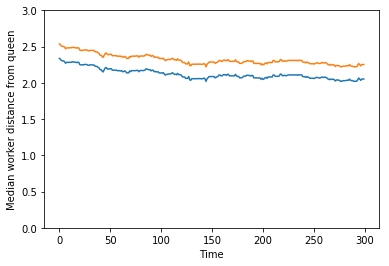

In [70]:
plt.plot(median_distances)
plt.plot(median_distances2)
plt.xlabel('Time')
plt.ylabel('Median worker distance from queen')
plt.ylim(0, 3)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
N_POOL = 20

### Simulate Input Data (genetic algorithm)

In [ ]:
X = np.zeros((N_POOL, 25, 25, 3))
X[:,14:15] = 1

#### Example of single image

In [ ]:
plt.imshow(X[0])

#### Create Mutations

In [ ]:
mutations = np.random.uniform(0, 1, size=X.shape)
mutations.shape

In [ ]:
np.random.uniform(0, 1, size=X.shape)

In [ ]:
mutations_mask = np.random.uniform(0, 1, size=X.shape) > 0.95
mutations_mask.shape

In [ ]:
mutations_mask

In [ ]:
X_mutations = np.copy(X)

In [ ]:
X_mutations[mutations_mask] = mutations[mutations_mask]

In [ ]:
rand_i = np.random.randint(X.shape[0])
plt.imshow(np.concatenate([X[rand_i], X_mutations[rand_i]], axis=1))

In [ ]:
X_target = np.zeros((25, 25, 3))
X_target[:,14:15] = 1
plt.imshow(X_target)

In [ ]:
np.expand_dims(X_target, axis=0).shape

In [ ]:
XX = np.tile(np.expand_dims(X_target, axis=0), (N_POOL, 1, 1, 1))

In [ ]:
plt.imshow(np.concatenate(XX[:5], axis=0))

In [ ]:
(X_mutations == X_target).sum(axis=(1,2,3))/num_pixels_per_individual

In [ ]:
X_target.shape

In [ ]:
X_target_broad = np.broadcast_to(X_target, shape=X.shape)
X_target_broad.shape

In [ ]:
plt.imshow(np.concatenate(X_target_broad[:5], axis=0))

In [ ]:
r = (X_mutations==X_target)
r.shape

In [ ]:
num_pixels_per_individual = np.product(X.shape[1:])
num_pixels_per_individual

In [ ]:
r.sum(axis=(1,2,3))/num_pixels_per_individual